In [8]:
# Reduce the embeddings dimensionality using UMAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import umap
from sklearn.decomposition import PCA

“How many PCA components capture most of the variance (information) in my embeddings?”

The x-axis = number of PCA components (from 1 → 100)
The y-axis = cumulative proportion of total variance explained

The red dashed line is 90% — meaning:
if we want to preserve 90% of the information in your data, we need however many components the curve crosses that line at.

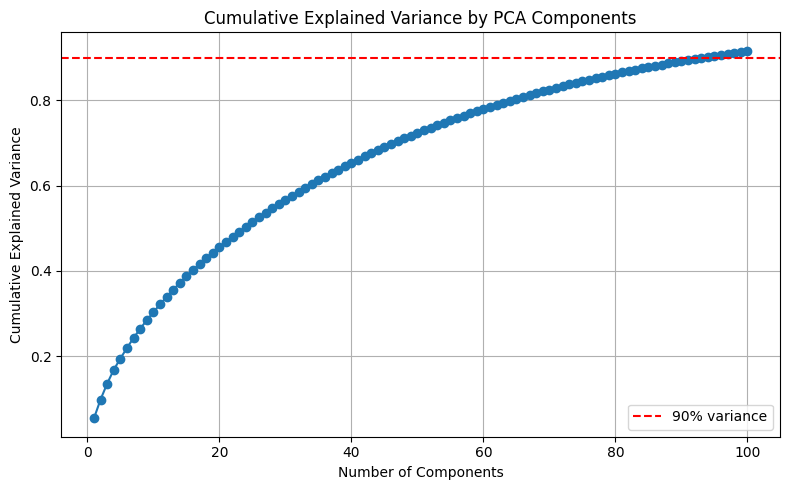

In [9]:
# Load embeddings
X = np.load("vectors/summaries.npy")

# Run PCA (enough components to see curve)
pca = PCA(n_components=min(100, X.shape[1]), random_state=42)
pca.fit(X)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative)+1), cumulative, marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.axhline(0.90, color="red", linestyle="--", label="90% variance")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
from kneed import KneeLocator
import numpy as np

knee = KneeLocator(range(1, len(cumulative)+1), cumulative, curve="concave", direction="increasing")
print(f"Elbow (knee) at component #{knee.knee}")

Elbow (knee) at component #35


This will automatically find groups of similar shows without any predefined labels.

Reduce embeddings with UMAP

In this one, we keep all the dimensions (we do not use the results from the PCA components above)

In [2]:
 
REPORTS = Path("reports"); REPORTS.mkdir(parents=True, exist_ok=True)

# Load embeddings + show index
X = np.load("vectors/summaries.npy")  # embeddings (n, d)
idx = pd.read_parquet("vectors/summaries_index.parquet")  # id + name

# UMAP to 2D for visualization
umap_model = umap.UMAP(
    n_neighbors=15,    # 5–50 controls how local/global the structure is
    min_dist=0.1,      # 0.0 → tight clusters, 0.5 → more spread
    n_components=2,
    metric="cosine",
    random_state=42
)
Z = umap_model.fit_transform(X)
idx["u1"], idx["u2"] = Z[:, 0], Z[:, 1]

# Save for later use
idx.to_parquet("data/shows_with_umap.parquet", index=False)
print(f"✅ Saved reduced coordinates: data/shows_with_umap.parquet")

c:\Users\brethm01\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Saved reduced coordinates: data/shows_with_umap.parquet


For this one, we use the PCA pre-reduction (to 35 components)

Notes: 
If you didn’t normalize your Sentence-Transformer embeddings during encoding, do it before PCA/UMAP (yours were normalized, so you’re good).
When using PCA first, it’s common to switch UMAP’s metric to "euclidean" on the PCA space (done below).
For small datasets, UMAP can get unstable with large n_neighbors; the guard keeps it in range.

In [12]:

REPORTS = Path("reports"); REPORTS.mkdir(parents=True, exist_ok=True)

# ---- Load data ----
X = np.load("vectors/summaries.npy")                     # (n, d)
idx = pd.read_parquet("vectors/summaries_index.parquet") # columns: id, name
assert X.shape[0] == len(idx), f"Embeddings rows {X.shape[0]} != index rows {len(idx)}"

n_samples = X.shape[0]

# ---- (Optional) PCA pre-reduction ----
USE_PCA = True
PCA_COMPONENTS = 35 # chosen based on prior analysis
if USE_PCA:
    pca = PCA(n_components=min(PCA_COMPONENTS, X.shape[1]), random_state=42)
    X_red = pca.fit_transform(X)
    print(f"PCA reduced from {X.shape[1]} → {X_red.shape[1]} dims "
          f"(cum var ~ {pca.explained_variance_ratio_.sum():.2%})")
else:
    X_red = X

# ---- UMAP 2D ----
n_neighbors = min(15, max(2, n_samples - 1))  # safety for small n
umap_model = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=0.1,
    n_components=2,
    metric="cosine" if not USE_PCA else "euclidean",  # after PCA, euclidean is typical
    random_state=42,
)
Z = umap_model.fit_transform(X_red)  # shape (n, 2)

# ---- Attach & save ----
idx = idx.copy()
idx["u1"] = Z[:, 0]
idx["u2"] = Z[:, 1]

# Save coordinates (parquet for data; npy for quick reload)
idx.to_parquet("data/shows_with_umap.parquet", index=False)
np.save("vectors/umap_2d.npy", Z)
print("✅ Saved: data/shows_with_umap.parquet and vectors/umap_2d.npy")

# ---- Quick plot for slides ----
#plt.figure(figsize=(8,6))
#plt.scatter(idx["u1"], idx["u2"], s=18, alpha=0.75)
#plt.title("UMAP (2D) of TV Show Embeddings")
#plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
#plt.tight_layout()
#out = REPORTS / "umap_2d.png"
#plt.savefig(out, dpi=200)
#plt.show()
#print("Saved plot:", out)

PCA reduced from 384 → 35 dims (cum var ~ 61.23%)


c:\Users\brethm01\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Saved: data/shows_with_umap.parquet and vectors/umap_2d.npy


Cluster the reduced embeddings (unsupervised)
We use HDBSCAN (automatic number of clusters, robust) instead of K-Means (fixed number)

In [5]:
#import hdbscan

#clusterer = hdbscan.HDBSCAN(
#    min_cluster_size=5,   # try 5–30 based on dataset size
#    metric="euclidean"
#)
#labels = clusterer.fit_predict(Z)
#idx["cluster"] = labels

#print(f"Found {len(set(labels)) - (1 if -1 in labels else 0)} clusters (+ noise)")

In [16]:
REPORTS = Path("reports"); REPORTS.mkdir(parents=True, exist_ok=True)

# Safety: make sure UMAP coords exist
assert {"u1", "u2"}.issubset(idx.columns), "UMAP step must run first (u1/u2 missing)."

# Choose number of clusters
K = 5  # <--- adjust here

# Run K-Means on 2D UMAP coordinates
X2 = idx[["u1", "u2"]].values
K = min(K, len(idx)) if len(idx) > 0 else K  # guard for tiny datasets
km = KMeans(n_clusters=K, random_state=42, n_init="auto")
idx["cluster"] = km.fit_predict(X2)

# Save clustered data
out_parquet = Path("data/shows_with_umap_kmeans.parquet")
idx.to_parquet(out_parquet, index=False)
print("✅ Saved clustered data:", out_parquet.resolve())

✅ Saved clustered data: C:\Users\brethm01\tv-nlp\src\data\shows_with_umap_kmeans.parquet


Visualize clusters

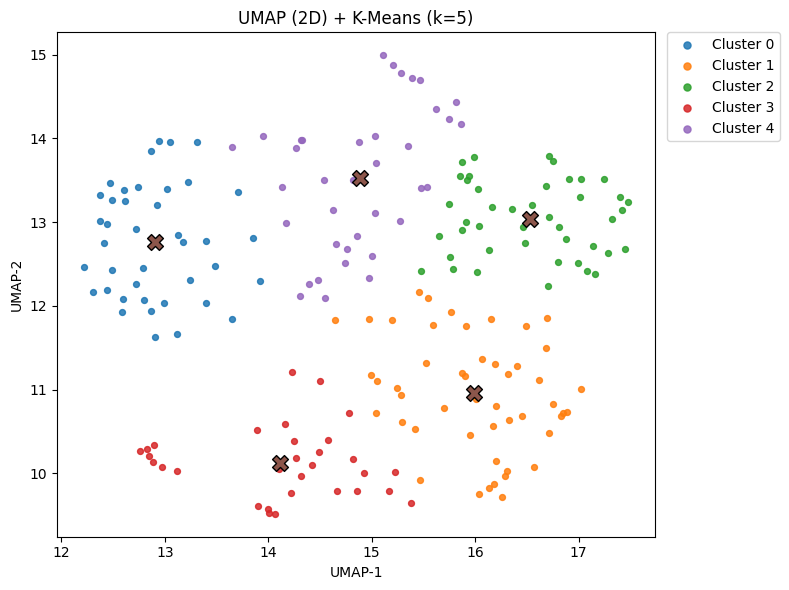

📈 Saved plot: reports\umap_kmeans_k5.png


In [17]:
# Plot clusters with centroids
plt.figure(figsize=(8, 6))
for lab in sorted(pd.unique(idx["cluster"])):
    m = (idx["cluster"] == lab)
    plt.scatter(idx.loc[m, "u1"], idx.loc[m, "u2"], s=18, alpha=0.85, label=f"Cluster {lab}")

cent = km.cluster_centers_
plt.scatter(cent[:, 0], cent[:, 1], s=130, marker="X", edgecolors="k", linewidths=1.0)

plt.title(f"UMAP (2D) + K-Means (k={K})")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(markerscale=1.2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
out_png = REPORTS / f"umap_kmeans_k{K}.png"
plt.savefig(out_png, dpi=200)
plt.show()
print("📈 Saved plot:", out_png)


Each dot = one TV show.
Nearby dots = similar content or themes.
Far-apart dots = semantically different shows.
If you color the dots by cluster, you’ll see distinct groups (e.g., comedies vs. documentaries).

In [21]:
# Silhouette score (quality metric, higher ≈ better separation)
if K >= 2 and len(idx) > K:
    sil = silhouette_score(X2, idx["cluster"])
    print(f"Silhouette score (UMAP space): {sil:.3f}")

# Peek a few titles per clusterwhat
def sample_per_cluster(frame, k=3):
    parts = []
    for lab in sorted(frame["cluster"].unique()):
        parts.append(frame[frame["cluster"] == lab][["cluster", "id", "name"]].head(k))
    return pd.concat(parts, axis=0)

preview = sample_per_cluster(idx, k=5)
print("\nSample shows per cluster:\n", preview.to_string(index=False))


Silhouette score (UMAP space): 0.418

Sample shows per cluster:
  cluster  id               name
       0   8               Glee
       0  28    Californication
       0  41  Last Man Standing
       0  53          Nashville
       0  55   Red Band Society
       1   1     Under the Dome
       1   3             Bitten
       1   9            Revenge
       1  10              Grimm
       1  12          Lost Girl
       2   2 Person of Interest
       2   5     True Detective
       2   7           Homeland
       2  11             Gotham
       2  14          Continuum
       3   6            The 100
       3  18   The Amazing Race
       3  20         The Strain
       3  21      The Last Ship
       3  34              Helix
       4   4              Arrow
       4  13          The Flash
       4  46            Forever
       4  48    Madam Secretary
       4  50        The Lottery


In [23]:
 

# Load the base data (from your earlier review CSV)
review_df = pd.read_csv("data/shows_for_review.csv")

# Load the UMAP + K-Means clusters
clustered_df = pd.read_parquet("data/shows_with_umap_kmeans.parquet")

# Merge both datasets on the 'id' column
df = pd.merge(
    review_df,
    clustered_df[["id", "u1", "u2", "cluster"]],
    on="id",
    how="left"
)

# Inspect the result
print(df.shape)
df.head()

(485, 8)


,id,name,genres,original_summary,ai_summary,u1,u2,cluster
0,1,Under the Dome,"['Drama', 'Science-Fiction', 'Thriller']",Under the Dome is the story of a small town th...,**Under the Dome** follows the residents of Ch...,16.613955,11.111692,1.0
1,2,Person of Interest,"['Action', 'Crime', 'Science-Fiction']",You are being watched. The government has a se...,"In ""Person of Interest,"" a reclusive billionai...",16.163136,13.185215,2.0
2,3,Bitten,"['Drama', 'Horror', 'Romance']",Based on the critically acclaimed series of no...,"In *Bitten*, follow Elena Michaels, the world’...",16.131466,9.820217,1.0
3,4,Arrow,"['Drama', 'Action', 'Science-Fiction']","After a violent shipwreck, billionaire playboy...","In ""Arrow,"" billionaire playboy Oliver Queen r...",15.530833,13.422974,4.0
4,5,True Detective,"['Drama', 'Crime', 'Thriller']",Touch darkness and darkness touches you back. ...,"In **True Detective**, each season unveils a g...",17.284245,12.632518,2.0


In [25]:
# Explode genres (since each show can have multiple)
df_exp = df.explode("genres")

# Calculate top genres per cluster
summary = (
    df_exp.groupby("cluster")["genres"]
    .value_counts(normalize=True)
    .rename("genre_share")
    .reset_index()
)

# Get the top 3 genres per cluster
top_genres = summary.groupby("cluster").head(3)
print(top_genres)

    cluster                                      genres  genre_share
0       0.0                                  ['Comedy']     0.275000
1       0.0                        ['Comedy', 'Family']     0.250000
2       0.0                       ['Comedy', 'Romance']     0.100000
11      1.0        ['Drama', 'Romance', 'Supernatural']     0.081633
12      1.0             ['Drama', 'Horror', 'Thriller']     0.061224
13      1.0    ['Drama', 'Science-Fiction', 'Thriller']     0.061224
48      2.0                ['Drama', 'Action', 'Crime']     0.186047
49      2.0              ['Drama', 'Crime', 'Thriller']     0.139535
50      2.0                          ['Drama', 'Crime']     0.093023
72      3.0  ['Action', 'Adventure', 'Science-Fiction']     0.193548
73      3.0                                          []     0.129032
74      3.0             ['Drama', 'Action', 'Thriller']     0.064516
93      4.0                                  ['Comedy']     0.108108
94      4.0                       

Generate a per-cluster score table

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

# Load clustered data and coordinates
df = pd.read_parquet("data/shows_with_umap_kmeans.parquet")   # has u1, u2, cluster
X = df[["u1", "u2"]].values

# Recreate or reuse your KMeans model
from sklearn.cluster import KMeans
k = df["cluster"].nunique()
km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X)

# ---- Compute distances of every point to every centroid ----
D = euclidean_distances(X, km.cluster_centers_)   # shape (n_samples, k)
# Convert distances to "similarity" scores (smaller distance = higher score)
S = 1 / (1 + D)                                   # simple invert; can also use exp(-D)

# Normalize across clusters so each row sums to 1
S = S / S.sum(axis=1, keepdims=True)

# ---- Build a DataFrame with cluster scores ----
cluster_cols = [f"cluster_{i}_score" for i in range(k)]
scores_df = pd.DataFrame(S, columns=cluster_cols)
scores_df["id"] = df["id"]
scores_df["name"] = df["name"]
scores_df["assigned_cluster"] = df["cluster"]

# Preview
print("📈 Cluster score preview:")
print(scores_df.head(10).to_string(index=False))

# Save
out_path = "data/show_cluster_scores.parquet"
scores_df.to_parquet(out_path, index=False)
print(f"✅ Saved: {out_path}  ({scores_df.shape[0]} shows × {scores_df.shape[1]} cols)")

📈 Cluster score preview:
 cluster_0_score  cluster_1_score  cluster_2_score  cluster_3_score  cluster_4_score  id               name  assigned_cluster
        0.118324         0.364461         0.204406         0.162272         0.150536   1     Under the Dome                 1
        0.122912         0.162567         0.375792         0.112459         0.226270   2 Person of Interest                 2
        0.131213         0.328321         0.165875         0.231403         0.143188   3             Bitten                 1
        0.145287         0.153275         0.259261         0.117355         0.324822   4              Arrow                 4
        0.121874         0.210193         0.353997         0.130038         0.183897   5     True Detective                 2
        0.144682         0.190042         0.119728         0.417425         0.128123   6            The 100                 3
        0.151857         0.214152         0.244325         0.149063         0.240603   7     